In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
from getpass import getpass
import pathlib
import json
import pandas as pd
import numpy as np
import csv
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from tqdm.notebook import tqdm
from typing import List

LOCAL_PATH = "/tmp/patent-analysis"
DATA_PATH = os.path.join(LOCAL_PATH, 'dataset')
PERMANENT_STORAGE = "/patent-analysis/dataset"

sys.path.append(LOCAL_PATH)

import dask.dataframe as dask
from dask.distributed import Client

from utils.stats import print_ddf_stats
from utils.dask_utils import month_diff, year_diff, compute_ltc
from data.load_data_api import END_YEAR, END_MONTH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ncpus = len(os.sched_getaffinity(0))
print("Number of CPUs available:", ncpus)
client = Client(n_workers=32, threads_per_worker=2, memory_limit='7GB', dashboard_address='6006')
client

Number of CPUs available: 64


Client Scheduler: tcp://127.0.0.1:40229 Dashboard: http://127.0.0.1:6006/status,Cluster Workers: 32 Cores: 64 Memory: 224.00 GB


In [66]:
ddf = dask.read_parquet("/patent-analysis/datasets/api/*-patent.parquet")

In [67]:
ddf.head()

,patent_title,patent_date,patent_kind,patent_type,inventor_id,inventor_first_name,inventor_last_name,inventor_location_id,inventor_city,inventor_state,...,assignee_longitude,assignee_sequence,assignee_type,assignee_key_id,cpc_section_id,cpc_subsection_id,cpc_group_id,cpc_subgroup_id,cpc_category,cpc_sequence
3930271,Golf glove,1976-01-06,A,utility,None,None,None,None,None,None,...,-87.65,0,2,411208,A,A63,A63B,A63B71/146,inventional,0
3930272,Crib leg lock,1976-01-06,A,utility,None,None,None,None,None,None,...,-78.5042,0,2,110820,A,A47,A47D,A47D7/02,inventional,0
3930272,Crib leg lock,1976-01-06,A,utility,None,None,None,None,None,None,...,-78.5042,0,2,110820,Y,Y10,Y10T,Y10T403/32451,additional,1
3930273,Bed safety side rail arrangement,1976-01-06,A,utility,3930273-1,Robert,Stern,38.627|-90.1994,St. Louis,MO,...,-90.1994,0,2,432504,A,A61,A61G,A61G7/0507,inventional,0
3930273,Bed safety side rail arrangement,1976-01-06,A,utility,3930273-1,Robert,Stern,38.627|-90.1994,St. Louis,MO,...,-90.1994,0,2,432504,A,A61,A61G,A61G7/0509,inventional,1


In [5]:
len(ddf)

124707016

In [262]:
ddf.columns

Index(['patent_title', 'patent_date', 'patent_kind', 'patent_type',
       'inventor_id', 'inventor_first_name', 'inventor_last_name',
       'inventor_location_id', 'inventor_city', 'inventor_state',
       'inventor_country', 'inventor_latitude', 'inventor_longitude',
       'inventor_sequence', 'inventor_key_id', 'assignee_id',
       'assignee_organization', 'assignee_first_name', 'assignee_last_name',
       'assignee_location_id', 'assignee_city', 'assignee_state',
       'assignee_country', 'assignee_latitude', 'assignee_longitude',
       'assignee_sequence', 'assignee_type', 'assignee_key_id',
       'cpc_section_id', 'cpc_subsection_id', 'cpc_group_id',
       'cpc_subgroup_id', 'cpc_category', 'cpc_sequence'],
      dtype='object')

## Plot the pie-chart of the patent distribution per assignee

In [11]:
assignee_country_counts = ddf.map_partitions(lambda x: x.groupby(x.index)['assignee_country'].first()).compute()
assignee_country_counts = assignee_country_counts.value_counts()
assignee_country_counts

US    3409663
JP    1305627
DE     394096
KR     272642
TW     179238
       ...   
NM          1
WF          1
VA          1
ZW          1
CT          1
Name: assignee_country, Length: 206, dtype: int64

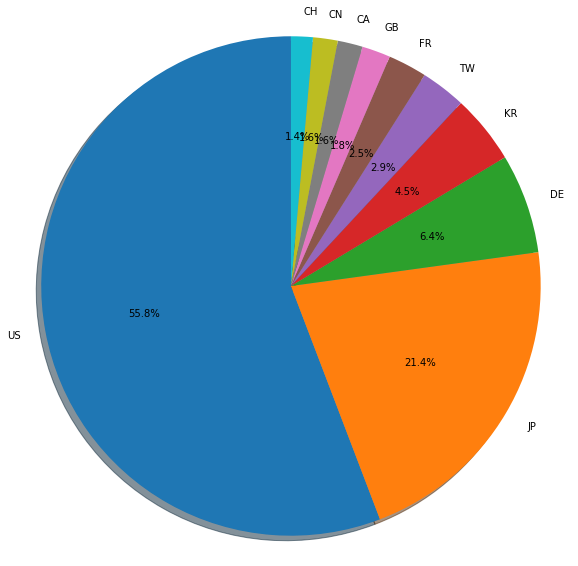

In [12]:
x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot the pie-chart of the patent distribution per inventor

In [14]:
inventor_country_counts = ddf.map_partitions(lambda x: x.groupby(x.index)['inventor_country'].first()).compute()
inventor_country_counts = inventor_country_counts.value_counts()
inventor_country_counts

US    3900358
JP    1322331
DE     445344
KR     274496
TW     221435
       ...   
TS          1
ER          1
LY          1
RC          1
OK          1
Name: inventor_country, Length: 240, dtype: int64

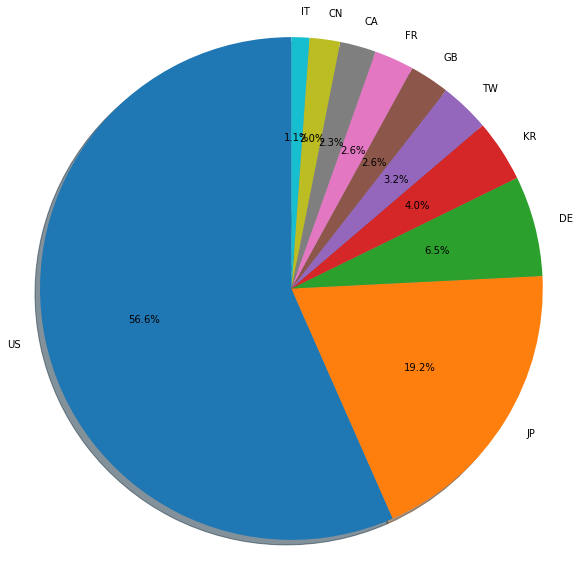

In [15]:
x = dict(100 * inventor_country_counts[:10] / inventor_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot distribution of patent types and kinds

In [17]:
patent_type = ddf.map_partitions(lambda x: x.groupby(x.index)['patent_type'].first()).compute()
patent_type = patent_type.value_counts()
patent_type

utility                             6824356
design                               654231
plant                                 28219
reissue                               19386
statutory invention registration       2259
defensive publication                   509
TVPP                                      3
Name: patent_type, dtype: int64

In [18]:
patent_kind= ddf.map_partitions(lambda x: x.groupby(x.index)['patent_kind'].first()).compute()
patent_kind = patent_kind.value_counts()
patent_kind

B2    3781915
A     2391379
B1     651063
S1     444649
S      209582
P2      13549
E1      10694
E        8692
P        8282
P3       6388
H        1982
I4        509
H1        273
H2          3
I5          3
Name: patent_kind, dtype: int64

## The distribution of the number of inventors per patent

         inventor_id
3930271            0
3930272            0
3930273            1
3930274            1
3930275            1
...              ...
RE48230           10
RE48231            6
RE48232            8
RE48233            3
RE48234            5

[7528963 rows x 1 columns]


<AxesSubplot:ylabel='Count'>

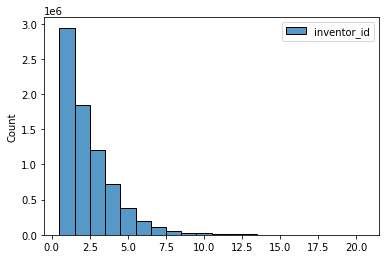

In [19]:
inventor_counts = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'inventor_id': "nunique"})).compute()

print(inventor_counts)
sns.histplot(inventor_counts, bins=20, binrange=(1,20), discrete=True)

## The evolution of percentage of patents with a given number of inventor and a given number of geo-locations (cities) involved

In [41]:
geo_counts_time = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'patent_date': 'first', 
                                                                        'inventor_state': "nunique", 
                                                                        'inventor_city': "nunique", 
                                                                        'inventor_id': "nunique"})).compute()
geo_counts_time['year'] = geo_counts_time['patent_date'].dt.year

In [43]:
inventor_counts_time = geo_counts_time.groupby('year')['inventor_id'].value_counts(normalize=True).to_frame()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'proportion'}).reset_index()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'inventor_count'})
inventor_counts_time = inventor_counts_time.groupby(['inventor_count', 'year']).agg({'proportion': 'first'})

city_counts_time = geo_counts_time.groupby('year')['inventor_city'].value_counts(normalize=True).to_frame()
city_counts_time = city_counts_time.rename(columns={'inventor_city': 'proportion'}).reset_index()
city_counts_time = city_counts_time.rename(columns={'inventor_city': 'city_count'})
city_counts_time = city_counts_time.groupby(['city_count', 'year']).agg({'proportion': 'first'})

inventor_counts_time.head()

proportion
inventor_count year            
0              1976    0.000479
               1977    0.000129
               1978    0.000170
               1979    0.000171
               1980    0.000362

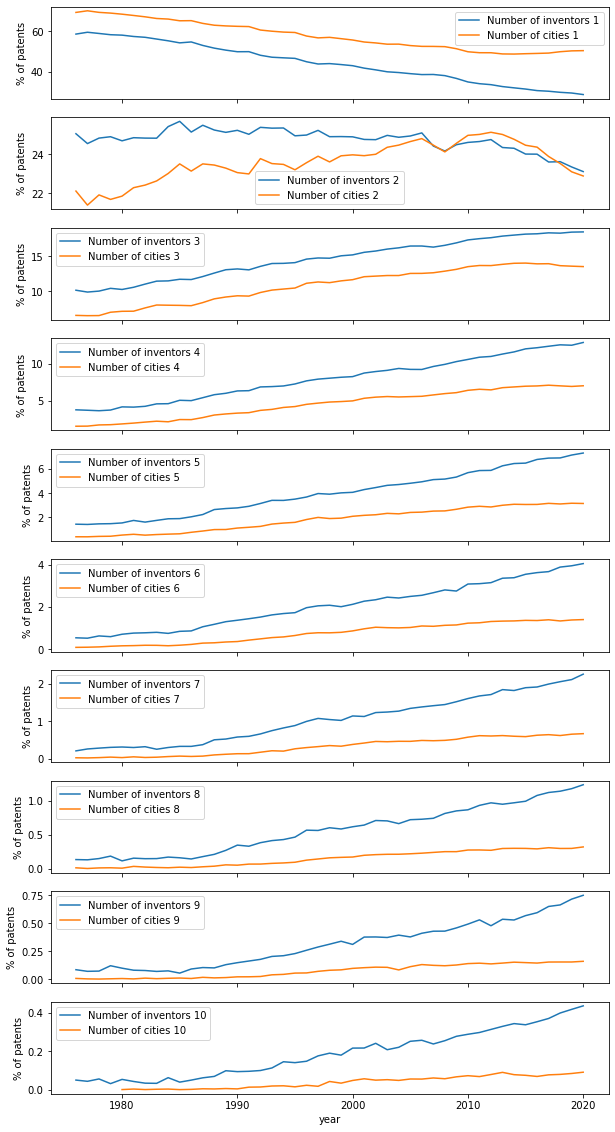

In [44]:
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(1, 11)):
    (100*inventor_counts_time.loc[count] ).plot(ax=axes[i])
    (100*city_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of inventors {i+1}", f"Number of cities {i+1}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The distribution of the number of 4-character CPC codes per patent

         cpc_group_id
3930271             1
3930272             2
3930273             1
3930274             1
3930275             5
...               ...
RE48230             0
RE48231             0
RE48232             0
RE48233             0
RE48234             0

[7528963 rows x 1 columns]


<AxesSubplot:ylabel='Count'>

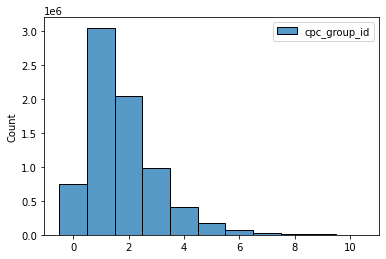

In [47]:
cpc4_code_counts = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'cpc_group_id': "nunique"})).compute()

print(cpc4_code_counts)
sns.histplot(cpc4_code_counts, bins=11, binrange=(0,10), discrete=True)

## The evolution of percentage of patents with a given number of CPC4 codes

In [50]:
cpc4_code_counts_time = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'patent_date': 'first',
                                                                              'cpc_group_id': "nunique"})).compute()
cpc4_code_counts_time['year'] = cpc4_code_counts_time['patent_date'].dt.year

In [51]:
cpc4_code_counts_time = cpc4_code_counts_time.groupby('year')['cpc_group_id'].value_counts(normalize=True).to_frame()
cpc4_code_counts_time = cpc4_code_counts_time.rename(columns={'cpc_group_id': 'proportion'}).reset_index()
cpc4_code_counts_time = cpc4_code_counts_time.rename(columns={'cpc_group_id': 'CPC4_count'})
cpc4_code_counts_time = cpc4_code_counts_time.groupby(['CPC4_count', 'year']).agg({'proportion': 'first'})
cpc4_code_counts_time

proportion
CPC4_count year            
0          1976    0.013039
           1977    0.068032
           1978    0.065027
           1979    0.070174
           1980    0.066785
...                     ...
30         2017    0.000009
           2018    0.000032
           2019    0.000038
           2020    0.000017
38         2020    0.000003

[850 rows x 1 columns]

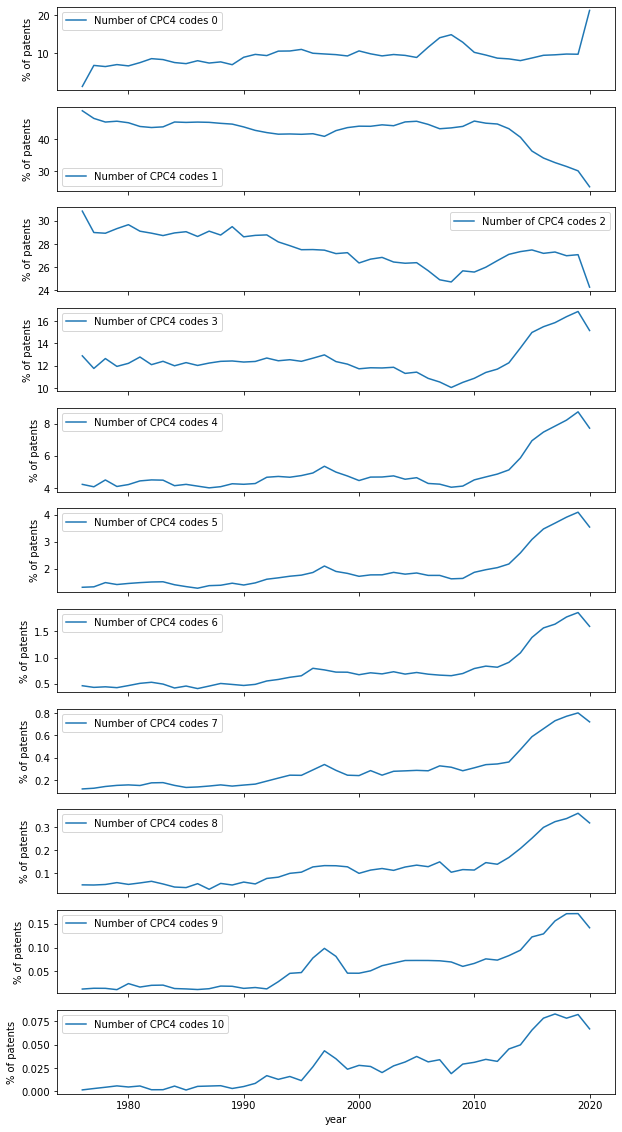

In [53]:
fig, axes = plt.subplots(11, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(0, 11)):
    (100*cpc4_code_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of CPC4 codes {i}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The distribution of patents across CPC4 codes

In [60]:
CPC4_code_counts = ddf.map_partitions(lambda x: x.reset_index()[['index', 'cpc_group_id']].drop_duplicates().\
                                     groupby('cpc_group_id').nunique()).compute()
CPC4_code_counts = CPC4_code_counts.groupby('cpc_group_id').sum().sort_values('index', ascending=False)


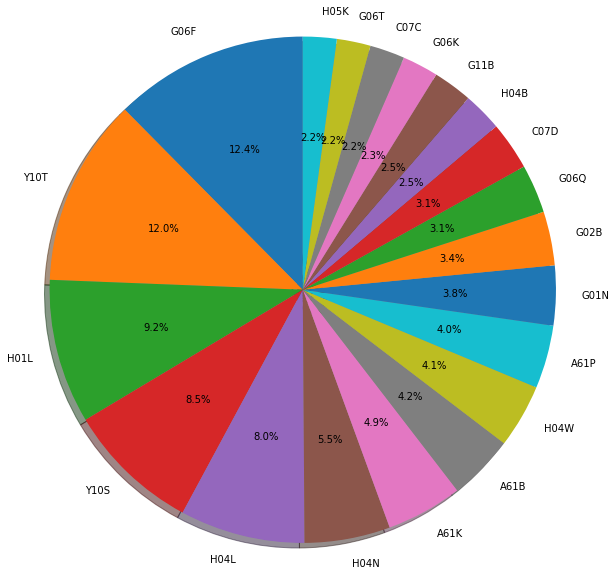

In [63]:
x = dict(100 * CPC4_code_counts['index'][:20] / CPC4_code_counts.values.sum())

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

<AxesSubplot:xlabel='cpc_group_id', ylabel='index'>

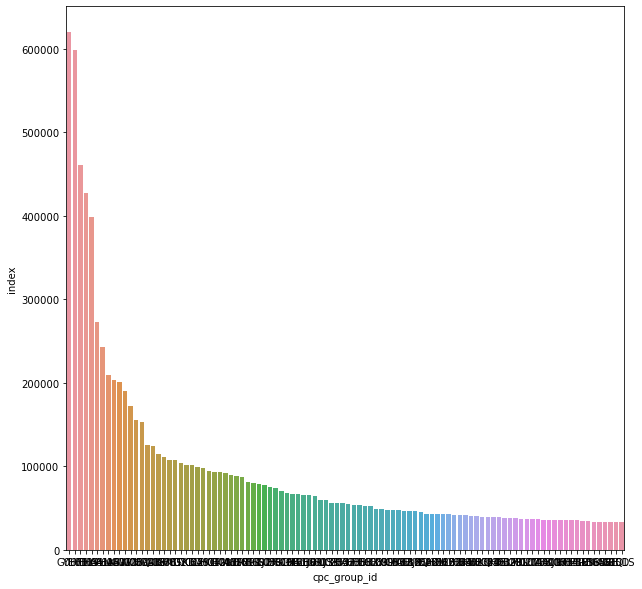

In [64]:
fig1, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='cpc_group_id', y='index', 
            data=CPC4_code_counts.reset_index()[:100])

## The distribution of years when a CPC4 group first appeared

<AxesSubplot:xlabel='index', ylabel='year'>

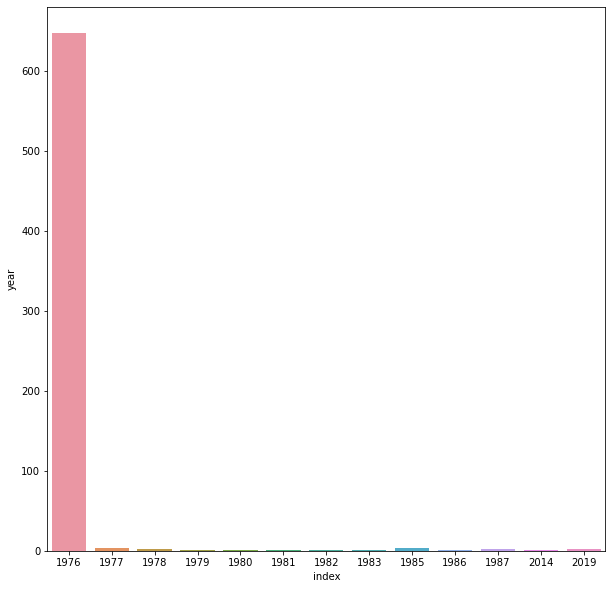

In [67]:
CPC4_code_appearance = ddf.map_partitions(lambda x: x[['cpc_group_id', 'patent_date']].drop_duplicates().\
                                     groupby('cpc_group_id').min()).compute()
CPC4_code_appearance['year'] = CPC4_code_appearance['patent_date'].dt.year

CPC4_code_appearance = CPC4_code_appearance.groupby('cpc_group_id').year.min()

fig1, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='index', y='year', 
            data=CPC4_code_appearance.value_counts().to_frame().reset_index())

## The appearance of new CPC4 codes over time

In [68]:
ddf['cpc_subgroup_id'].unique().compute()

0             A63B71/146
1               A47D7/02
2          Y10T403/32451
3             A61G7/0507
4             A61G7/0509
               ...      
240749    G05B2219/40481
240750         G06F16/65
240751         B01D23/10
240752       B01D33/0035
240753          H04Q5/14
Name: cpc_subgroup_id, Length: 240754, dtype: object

In [73]:
CPCFULL_code_appearance = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'patent_date']].drop_duplicates().\
                                     groupby('cpc_subgroup_id').min()).compute()

CPCFULL_code_appearance = CPCFULL_code_appearance.groupby('cpc_subgroup_id').min()
CPCFULL_code_appearance['patent_date'] = CPCFULL_code_appearance['patent_date'] +  pd.offsets.MonthBegin(0)
CPCFULL_code_appearance = CPCFULL_code_appearance.value_counts().to_frame().sort_index()

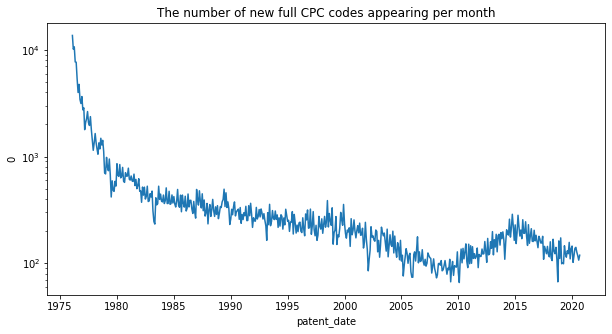

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=CPCFULL_code_appearance.reset_index(), x="patent_date", y=0)
plt.yscale('log')
plt.title("The number of new full CPC codes appearing per month")
print()

## The appearance of new full CPC codes over time, grouped by largest CPC4 codes

In [75]:
CPCFULL_code_appearance_stacked = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'patent_date']].drop_duplicates().\
                                     groupby('cpc_subgroup_id').min()).compute()
CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked.groupby('cpc_subgroup_id').min()
CPCFULL_code_appearance_stacked['year'] = CPCFULL_code_appearance_stacked['patent_date'].dt.year

CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked.join(
                                    ddf.groupby('cpc_subgroup_id')['cpc_group_id'].first().compute())
CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked[['year', 'cpc_group_id']].value_counts()
CPCFULL_code_appearance_stacked


year  cpc_group_id
1976  Y10T            5163
      Y10S            2664
      B29C            1617
      C07C            1523
      B65D            1322
                      ... 
1985  B82B               1
2003  G04G               1
1985  C01C               1
      C01D               1
2020  Y10S               1
Length: 17843, dtype: int64

In [77]:
top_groups_all = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.groupby('group_id').sum().sort_values(ascending=False)[:10].index.values]


top_groups_1970 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1970 & year < 1980").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_1980 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1980 & year < 1990").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_1990 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1990 & year < 2000").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_2000 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 2000 & year < 2010").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_2010 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 2010 & year < 2020").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]

top_groups_all = []
top_groups_all = set(top_groups_all + top_groups_1970 + top_groups_1980 + top_groups_1990 + top_groups_2000 + top_groups_2010)
# only preserve top 20
top_groups_all = list(top_groups_all)[:20]
top_groups_all = ",".join(top_groups_all)
top_groups_all

CPCFULL_code_appearance_stacked_top = CPCFULL_code_appearance_stacked.to_frame().query(f"group_id in [{top_groups_all}]")
CPCFULL_code_appearance_stacked_top = CPCFULL_code_appearance_stacked_top.unstack()
CPCFULL_code_appearance_stacked_top

0                                                               \
group_id    Y10T    Y10S    B29C    C07C    B65D    H01L   B01D   G01N   B65H   
year                                                                            
1976      5163.0  2664.0  1617.0  1523.0  1322.0  1234.0  987.0  978.0  820.0   
1977      1316.0   686.0   399.0   299.0   318.0   396.0  251.0  271.0  240.0   
1978       703.0   366.0   241.0   181.0   205.0   205.0  169.0  170.0  112.0   
1979       329.0   197.0   124.0   107.0   136.0   160.0   98.0  123.0  101.0   
1980       355.0   189.0   109.0   124.0   141.0   159.0   86.0   96.0  100.0   
1981       282.0   163.0   105.0    86.0    71.0   122.0   98.0  123.0   61.0   
1982       170.0   103.0    87.0    69.0    49.0   115.0   57.0   79.0   70.0   
1983       134.0    95.0    93.0    68.0    49.0    95.0   47.0   74.0   54.0   
1984       138.0    96.0    70.0    66.0    52.0   107.0   43.0   90.0   75.0   
1985       126.0    96.0    62.0    65.0    54.0   136.0   35.0   89.0   59.0   
1986       116.0    90.0    57.0    47.0    33.0   111.0   38.0   76.0   63.0   
1987        92.0   100.0    64.0    47.0    32.0    93.0   29.0  109.0   52.0   
1988        71.0    65.0    55.0    36.0    49.0   119.0   38.0   91.0   42.0   
1989        63.0    94.0    62.0    95.0    53.0   156.0   34.0  108.0   50.0   
1990        38.0    96.0    48.0    81.0    34.0   127.0   17.0   83.0   38.0   
1991        50.0    58.0    45.0    73.0    32.0   137.0   29.0   93.0   52.0   
1992        40.0    64.0    56.0    82.0    31.0   157.0   18.0   72.0   30.0   
1993        27.0    46.0    58.0    37.0    30.0    96.0   35.0   69.0   42.0   
1994        21.0    57.0    48.0    22.0    20.0   112.0   13.0   56.0   57.0   
1995        22.0    32.0    49.0    24.0    33.0    77.0   12.0   52.0   35.0   
1996        31.0    44.0    32.0    19.0    14.0    79.0   24.0   35.0   39.0   
1997        26.0    33.0    33.0    23.0    20.0   105.0   19.0   53.0   36.0   
1998        29.0    50.0    38.0    21.0    18.0   109.0   22.0   71.0   47.0   
1999        22.0    47.0    44.0    17.0    24.0   118.0   15.0   69.0   76.0   
2000        18.0    20.0    46.0    12.0    24.0    98.0   14.0   37.0   96.0   
2001         8.0    24.0    54.0    16.0    17.0   121.0   12.0   41.0   75.0   
2002        19.0    21.0    35.0    14.0    19.0    90.0   13.0   38.0   58.0   
2003        18.0    15.0    35.0    14.0    12.0   104.0    5.0   35.0   71.0   
2004        13.0    19.0    37.0     6.0     9.0   109.0   11.0   35.0   47.0   
2005        10.0    10.0    20.0     9.0    12.0   100.0    7.0   20.0   24.0   
2006         8.0     7.0    28.0    12.0     9.0    84.0   11.0   25.0   20.0   
2007        13.0     8.0    28.0     3.0    10.0    83.0    3.0   25.0   23.0   
2008         6.0    19.0    16.0     7.0     8.0    92.0   10.0   26.0   19.0   
2009         8.0    11.0    20.0     4.0     6.0   116.0   16.0   23.0   16.0   
2010         4.0    27.0    24.0     9.0    18.0   117.0   15.0   33.0   21.0   
2011         9.0    16.0    13.0     6.0    11.0   122.0   19.0   25.0   29.0   
2012         9.0    10.0    21.0     6.0    17.0   172.0   23.0   18.0   22.0   
2013         5.0    26.0    28.0     7.0    28.0   263.0   26.0   23.0   24.0   
2014         5.0    32.0    47.0    14.0    22.0   323.0   29.0   34.0   28.0   
2015         9.0    19.0    46.0    19.0    24.0   263.0   17.0   25.0   32.0   
2016         5.0     4.0    38.0    13.0    27.0   229.0   24.0   23.0   28.0   
2017         5.0     8.0    40.0    11.0    19.0   168.0   20.0   17.0   22.0   
2018         1.0     5.0    20.0    13.0    17.0   146.0   10.0   16.0   20.0   
2019         2.0     3.0    20.0    10.0    18.0   145.0    8.0   15.0   14.0   
2020         NaN     1.0     9.0     7.0     9.0   113.0   15.0    8.0    7.0   

                                                                         \
group_id   H01H   A61B   A61F   A61K   H04N   G06F 

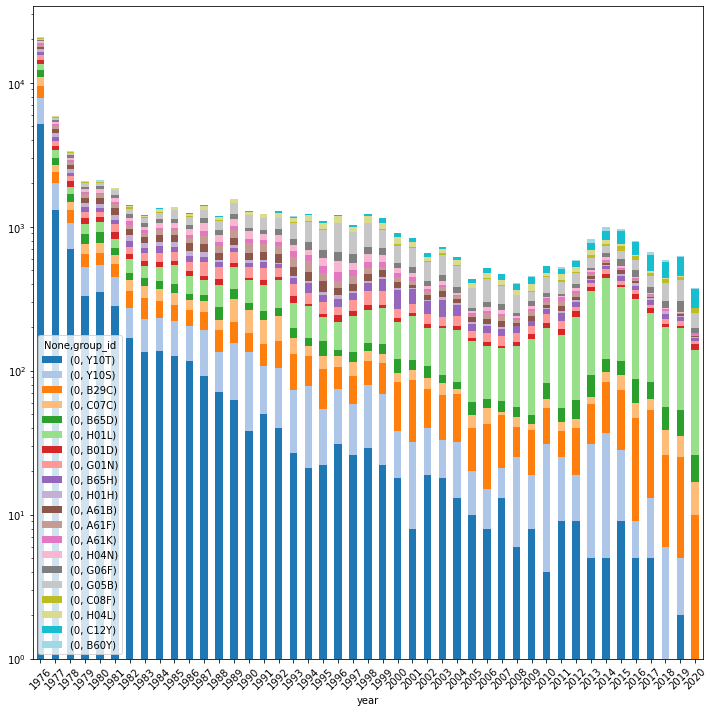

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))

cmap = cm.get_cmap('tab20', len(CPCFULL_code_appearance_stacked_top.columns))
colors = cmap(range(len(CPCFULL_code_appearance_stacked_top.columns)))

CPCFULL_code_appearance_stacked_top.plot(ax=ax, kind='bar', stacked=True, color=colors, rot=45)
plt.yscale('log')

In [81]:
CPCFULL_code_appearance_stacked_top.sum().sum()

72117.0

## The distribution of CPC codes per inventor

In [54]:
def remove_none(x: set) -> set:
    if None in x:
        x.remove(None)
    return x

CPCFULL_inventor = ddf.map_partitions(lambda x: x[['inventor_id', 'cpc_subgroup_id']].drop_duplicates().\
                                      groupby('inventor_id').\
                                      agg({'cpc_subgroup_id': lambda x: remove_none(set(x))})).\
                                      compute()
CPCFULL_inventor = CPCFULL_inventor.groupby('inventor_id').sum()
CPCFULL_inventor

,cpc_subgroup_id
inventor_id,
3930273-1,"{A61G7/0507, A61G7/0509}"
3930274-1,{B63B7/085}
3930275-1,"{B29C65/04, B29C51/267, B29K2027/06, B29C66/82..."
3930276-1,"{B60S3/004, B65G19/02, Y10S15/02}"
3930277-1,"{E01H1/0854, B62B3/08, A47L9/325, B62B3/12}"
...,...
RE48223-1,{}
RE48230-3,{}
RE48234-1,{}


In [63]:
def get_len(x: set):
    if isinstance(x, set):
        return int(len(x))
    else:
        0
    
CPCFULL_inventor["cpc_subgroup_id_count"] = CPCFULL_inventor['cpc_subgroup_id'].apply(lambda x: get_len(x))

<AxesSubplot:xlabel='cpc_subgroup_id_count', ylabel='Count'>

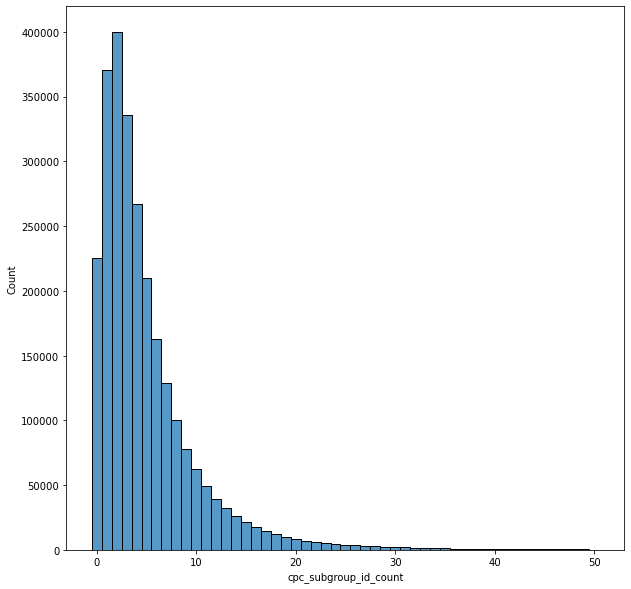

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.histplot(CPCFULL_inventor["cpc_subgroup_id_count"], bins=51, binrange=(0,50), discrete=True)

## The distribution of the number of codes per patent given the presence of a fresh code

In [67]:
CPCFULL_birth = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'patent_date']].\
                                       drop_duplicates().groupby('cpc_subgroup_id').min()).compute()
CPCFULL_birth = CPCFULL_birth.groupby('cpc_subgroup_id').min()
CPCFULL_birth

,patent_date
cpc_subgroup_id,
A01B1/00,1977-01-11
A01B1/02,1979-01-23
A01B1/022,1976-11-23
A01B1/024,1980-02-12
A01B1/026,1977-09-27
...,...
Y10T83/9495,1976-04-06
Y10T83/9498,1976-03-09
Y10T83/95,1976-01-13


In [84]:
# subgroup_id is CPC full code
# group_id is CPC 4-digit code

CPCFULL_patent = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'cpc_group_id', 'patent_date']].\
                                    reset_index().
                                    drop_duplicates().set_index('index'))
CPCFULL_patent = CPCFULL_patent.merge(
                      CPCFULL_birth, 
                      how='inner', left_on='cpc_subgroup_id', right_index=True, suffixes=['_actual','_birth']
    )
CPCFULL_patent['cpc_age'] = year_diff(CPCFULL_patent['patent_date_actual'], CPCFULL_patent['patent_date_birth'])
CPCFULL_patent = CPCFULL_patent.persist()

CPCFULL_patent.compute()

,cpc_subgroup_id,cpc_group_id,patent_date_actual,patent_date_birth,cpc_age
index,,,,,
3930271,A63B71/146,A63B,1976-01-06,1976-01-06,0
3931647,A63B71/146,A63B,1976-01-13,1976-01-06,0
3930272,A47D7/02,A47D,1976-01-06,1976-01-06,0
3934282,A47D7/02,A47D,1976-01-27,1976-01-06,0
3930272,Y10T403/32451,Y10T,1976-01-06,1976-01-06,0
...,...,...,...,...,...
10757848,H05F3/04,H05F,2020-08-25,1976-01-27,44
10757849,H05K2201/0358,H05K,2020-08-25,1980-10-07,40
10757849,H05K2203/1178,H05K,2020-08-25,1977-12-06,43


In [85]:
CPCFULL_birth_dates = CPCFULL_patent[['cpc_subgroup_id', 'patent_date_birth']].drop_duplicates().compute()
CPCFULL_birth_dates

,cpc_subgroup_id,patent_date_birth
index,,
3930271,A63B71/146,1976-01-06
3930272,A47D7/02,1976-01-06
3930272,Y10T403/32451,1976-01-06
3930273,A61G7/0507,1976-01-06
3930273,A61G7/0509,1976-01-06
...,...,...
10754308,G05B2219/40481,2020-08-25
10754890,G06F16/65,2020-08-25
10755824,B01D23/10,2020-08-25


In [86]:
CPCFULL_patent = CPCFULL_patent.map_partitions(
        lambda x: x.groupby('index').agg({'cpc_age': 'min', 
                                          'cpc_subgroup_id': 'nunique', 
                                          'cpc_group_id': 'nunique', 
                                          'patent_date_actual': 'first'})
    )
CPCFULL_patent

,cpc_age,cpc_subgroup_id,cpc_group_id,patent_date_actual
npartitions=537,,,,
,int64,int64,int64,datetime64[ns]
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [87]:
CPCFULL_patent_df = CPCFULL_patent.compute()
CPCFULL_patent_df

,cpc_age,cpc_subgroup_id,cpc_group_id,patent_date_actual
index,,,,
3930271,0,1,1,1976-01-06
3930272,0,2,2,1976-01-06
3930273,0,2,1,1976-01-06
3930274,0,1,1,1976-01-06
3930275,0,19,5,1976-01-06
...,...,...,...,...
10757847,32,9,4,2020-08-25
10757848,36,6,3,2020-08-25
10757849,33,6,1,2020-08-25


Text(0.5, 1.0, 'Distribution of patents with a given minimal CPC age')

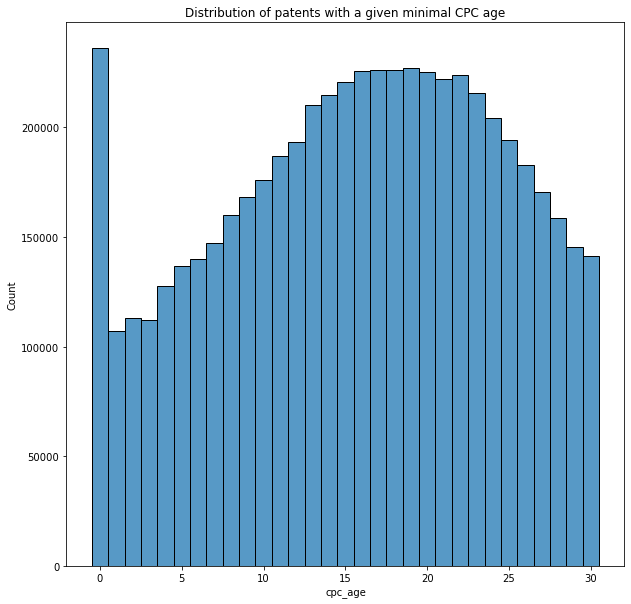

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.histplot(CPCFULL_patent_df['cpc_age'], bins=31, binrange=(0,30), discrete=True)
plt.title('Distribution of patents with a given minimal CPC age')

In [89]:
num_cpc_full_codes_year = {}
for year in [1990, 2000, 2010, 2020]:
    num_cpc_full_codes_year[year] = len(CPCFULL_birth_dates.query(f"patent_date_birth < {year}"))

print("The growth in the average number of full CPC codes w.r.t. baseline")
print(f"The baseline is 1990 and at this point we have {num_cpc_full_codes_year[1990]} full CPC codes")
for year in num_cpc_full_codes_year.keys():
    print(f"Increase in {year} w.r.t. 1990:", num_cpc_full_codes_year[year] / num_cpc_full_codes_year[1990])

The growth in the average number of full CPC codes w.r.t. baseline
The baseline is 1990 and at this point we have 174270 full CPC codes
Increase in 1990 w.r.t. 1990: 1.0
Increase in 2000 w.r.t. 1990: 1.1771733516956446
Increase in 2010 w.r.t. 1990: 1.2714867733976014
Increase in 2020 w.r.t. 1990: 1.3759338956791185


In [90]:
CPCFULL_patent_df.query("patent_date_actual > 1980 & patent_date_actual < 1990").groupby('cpc_age').mean()



,cpc_subgroup_id,cpc_group_id
cpc_age,,
0,5.927589,2.232733
1,5.453066,2.213600
2,5.137035,2.168243
3,4.571723,2.093078
4,3.495111,1.829686
5,3.442321,1.819594
6,3.435606,1.817163
7,3.381547,1.799419
8,3.266244,1.766648


In [91]:
CPCFULL_patent_df

,cpc_age,cpc_subgroup_id,cpc_group_id,patent_date_actual
index,,,,
3930271,0,1,1,1976-01-06
3930272,0,2,2,1976-01-06
3930273,0,2,1,1976-01-06
3930274,0,1,1,1976-01-06
3930275,0,19,5,1976-01-06
...,...,...,...,...
10757847,32,9,4,2020-08-25
10757848,36,6,3,2020-08-25
10757849,33,6,1,2020-08-25


Text(0.5, 1.0, 'Average number of Full CPC codes per patent as a function of the age of the youngest CPC code')

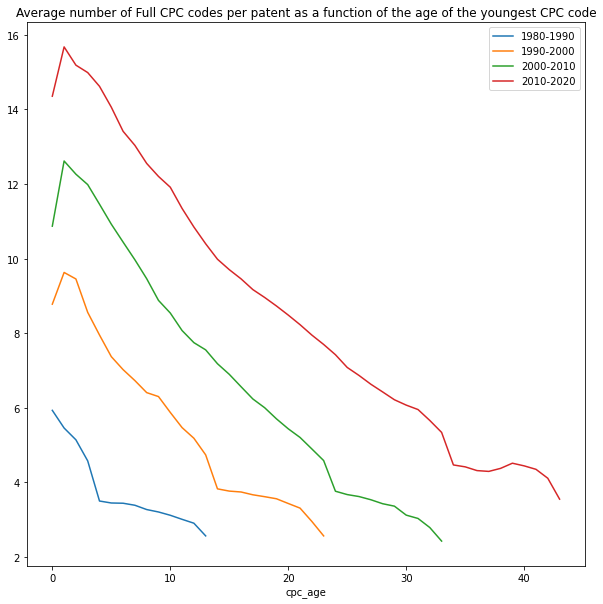

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

CPCFULL_patent_df.query("patent_date_actual > 1980 & patent_date_actual < 1990").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 1990 & patent_date_actual < 2000").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2000 & patent_date_actual < 2010").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2010 & patent_date_actual < 2020").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)

plt.legend(["1980-1990", "1990-2000", "2000-2010", "2010-2020"])
plt.title("Average number of Full CPC codes per patent as a function of the age of the youngest CPC code")

Text(0.5, 1.0, 'Average number of CPC 4-digit codes per patent as a function of the age of the youngest full CPC code')

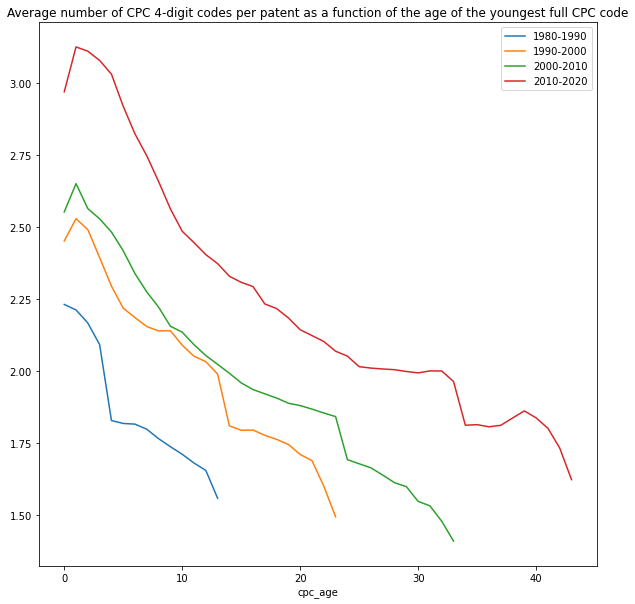

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))

CPCFULL_patent_df.query("patent_date_actual > 1980 & patent_date_actual < 1990").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 1990 & patent_date_actual < 2000").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2000 & patent_date_actual < 2010").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2010 & patent_date_actual < 2020").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)

plt.legend(["1980-1990", "1990-2000", "2000-2010", "2010-2020"])
plt.title("Average number of CPC 4-digit codes per patent as a function of the age of the youngest full CPC code")


In [3]:
ddf_citation = dask.read_parquet("/patent-analysis/datasets/api/*-citations.parquet")

In [4]:
ddf_citation.head()

,patent_date,cited_patent_number,cited_patent_date,cited_patent_sequence,citedby_patent_number,citedby_patent_date
3930271,1976-01-06,2379430,NaT,0,5135226,1992-08-04
3930271,1976-01-06,2379430,NaT,0,5592695,1997-01-14
3930271,1976-01-06,2379430,NaT,0,5621918,1997-04-22
3930271,1976-01-06,2379430,NaT,0,5624296,1997-04-29
3930271,1976-01-06,2379430,NaT,0,5675839,1997-10-14


In [ ]:
len(ddf_citation)

In [6]:
ddf_citation['citation_age'] = year_diff(ddf_citation['citedby_patent_date'], ddf_citation['patent_date'])
ddf_citation

,patent_date,cited_patent_number,cited_patent_date,cited_patent_sequence,citedby_patent_number,citedby_patent_date,citation_age
npartitions=537,,,,,,,
,datetime64[ns],object,datetime64[ns],object,object,datetime64[ns],int64
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [20]:
citation_age = ddf_citation['citation_age'].compute()

In [7]:
ddf_citation.head()

,patent_date,cited_patent_number,cited_patent_date,cited_patent_sequence,citedby_patent_number,citedby_patent_date,citation_age
3930271,1976-01-06,2379430,NaT,0,5135226,1992-08-04,16.0
3930271,1976-01-06,2379430,NaT,0,5592695,1997-01-14,21.0
3930271,1976-01-06,2379430,NaT,0,5621918,1997-04-22,21.0
3930271,1976-01-06,2379430,NaT,0,5624296,1997-04-29,21.0
3930271,1976-01-06,2379430,NaT,0,5675839,1997-10-14,21.0


In [193]:
ddf_citation_ltc = ddf_citation.map_partitions(lambda x: 
                            compute_ltc(x, 
                                        year_range = np.arange(1,16),
                                        last_date = pd.to_datetime(f"{END_YEAR}-{END_MONTH}-30"))
                                                ).compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


In [328]:
ddf_citation_ltc['year'] = ddf_citation_ltc.patent_date.dt.year.astype(np.int16)
ddf_citation_ltc

,CY1,CY2,CY3,CY4,CY5,CY6,CY7,CY8,CY9,CY10,...,CY13,CY14,CY15,patent_date,citedby_patent_date,cpc_group_id,cpc_group_code,cpc_subgroup_id,cpc_subgroup_code,year
index,,,,,,,,,,,,,,,,,,,,,
3930271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1976-01-06,1992-08-04,[A63B],"[77, 667, 667, 667, 667, 667, 667, 667, 667, 667]",[A63B71/146],"[26388, 240753, 240753, 240753, 240753, 240753...",1976
3930272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1976-01-06,2010-07-13,"[Y10T, A47D]","[666, 54, 667, 667, 667, 667, 667, 667, 667, 667]","[A47D7/02, Y10T403/32451]","[9659, 235900, 240753, 240753, 240753, 240753,...",1976
3930273,0.0,0.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,6.0,...,6.0,6.0,6.0,1976-01-06,2020-02-04,[A61G],"[65, 667, 667, 667, 667, 667, 667, 667, 667, 667]","[A61G7/0507, A61G7/0509]","[18790, 18792, 240753, 240753, 240753, 240753,...",1976
3930274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1976-01-06,2020-07-21,[B63B],"[226, 667, 667, 667, 667, 667, 667, 667, 667, ...",[B63B7/085],"[69762, 240753, 240753, 240753, 240753, 240753...",1976
3930275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1976-01-06,2003-12-23,"[B29L, A43D, B29C, B29K, A43B]","[159, 42, 156, 158, 40, 667, 667, 667, 667, 667]","[A43D8/08, A43B3/103, A43B3/106, A43D111/00, B...","[6745, 6359, 6361, 6643, 50671, 50995, 51363, ...",1976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE48230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2020-09-29,NaT,[None],"[667, 667, 667, 667, 667, 667, 667, 667, 667, ...",[None],"[240753, 240753, 240753, 240753, 240753, 24075...",2020
RE48231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2020-09-29,NaT,[None],"[667, 667, 667, 667, 667, 667, 667, 667, 667, ...",[None],"[240753, 240753, 240753, 240753, 240753, 24075...",2020
RE48232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2020-09-29,NaT,[None],"[667, 667, 667, 667, 667, 667, 667, 667, 667, ...",[None],"[240753, 240753, 240753, 240753, 240753, 24075...",2020


In [317]:
subgroup_id = ddf[['cpc_subgroup_id']].drop_duplicates().compute()

subgroup_id["cpc_subgroup_code"] = encoder.fit_transform(subgroup_id[['cpc_subgroup_id']]).astype(np.int32)
subgroup_id = subgroup_id.set_index('cpc_subgroup_id')

subgroup_id

,cpc_subgroup_code
cpc_subgroup_id,
A63B71/146,26388
A47D7/02,9659
Y10T403/32451,235900
A61G7/0507,18790
A61G7/0509,18792
...,...
G05B2219/40481,175644
G06F16/65,179104
B01D23/10,29512


In [318]:
from sklearn.preprocessing import OrdinalEncoder

def pad_with(x, pad_size: int, pad_object: int):
    if len(x) > pad_size:
        return x[:pad_size]
    else:
        return x + (pad_size - len(x))*[pad_object]

# cpc_subsection = ddf.reset_index()[['index', 'cpc_subgroup_id']].drop_duplicates().compute().set_index('index')

# encoder = OrdinalEncoder()
# cpc_subsection["cpc_subgroup_code"] = encoder.fit_transform(cpc_subsection[["cpc_subgroup_id"]]).astype(np.int16)

# cpc_subsection_ddf = dask.from_pandas(cpc_subsection, npartitions=32)

# Aggregate cpc field into list
cpc_subsection = ddf.map_partitions(lambda x: x.reset_index()[['index', 'cpc_subgroup_id']].drop_duplicates().set_index('index'))
cpc_subsection = cpc_subsection.map_partitions(lambda x: x.join(subgroup_id, on='cpc_subgroup_id')
                                    .groupby(x.index).agg(
                                        {'cpc_subgroup_id': list, 
                                         'cpc_subgroup_code': list})).compute()

# Pad cpc code list to length 10 to avoid dealing with variable sequence length
none_code = encoder.transform([[None]])[0,0].astype(np.int32)
cpc_subsection['cpc_subgroup_code'] = cpc_subsection['cpc_subgroup_code'].apply(
    lambda x: pad_with(x, pad_size=30, pad_object=none_code))


cpc_subsection.head(11)


,cpc_subgroup_id,cpc_subgroup_code
index,,
3930271,[A63B71/146],"[26388, 240753, 240753, 240753, 240753, 240753..."
3930272,"[A47D7/02, Y10T403/32451]","[9659, 235900, 240753, 240753, 240753, 240753,..."
3930273,"[A61G7/0507, A61G7/0509]","[18790, 18792, 240753, 240753, 240753, 240753,..."
3930274,[B63B7/085],"[69762, 240753, 240753, 240753, 240753, 240753..."
3930275,"[A43D8/08, A43B3/103, A43B3/106, A43D111/00, B...","[6745, 6359, 6361, 6643, 50671, 50995, 51363, ..."
3930276,"[B60S3/004, B65G19/02, Y10S15/02]","[65171, 75924, 225896, 240753, 240753, 240753,..."
3930277,[E01H1/0854],"[120069, 240753, 240753, 240753, 240753, 24075..."
3930278,"[A46B17/08, B44D3/225]","[8099, 58807, 240753, 240753, 240753, 240753, ..."
3930279,"[B60S1/3801, B60S2001/382, B60S2001/3836]","[65042, 65138, 65147, 240753, 240753, 240753, ..."


In [319]:
cpc_subsection

,cpc_subgroup_id,cpc_subgroup_code
index,,
3930271,[A63B71/146],"[26388, 240753, 240753, 240753, 240753, 240753..."
3930272,"[A47D7/02, Y10T403/32451]","[9659, 235900, 240753, 240753, 240753, 240753,..."
3930273,"[A61G7/0507, A61G7/0509]","[18790, 18792, 240753, 240753, 240753, 240753,..."
3930274,[B63B7/085],"[69762, 240753, 240753, 240753, 240753, 240753..."
3930275,"[A43D8/08, A43B3/103, A43B3/106, A43D111/00, B...","[6745, 6359, 6361, 6643, 50671, 50995, 51363, ..."
...,...,...
RE48230,[None],"[240753, 240753, 240753, 240753, 240753, 24075..."
RE48231,[None],"[240753, 240753, 240753, 240753, 240753, 24075..."
RE48232,[None],"[240753, 240753, 240753, 240753, 240753, 24075..."


In [238]:
# from sklearn.preprocessing import OrdinalEncoder

# def pad_with(x, pad_size: int, pad_object: int):
#     if len(x) > pad_size:
#         return x[:pad_size]
#     else:
#         return x + (pad_size - len(x))*[pad_object]

# cpc_subsection = ddf.reset_index()[['index', 'cpc_group_id']].drop_duplicates().compute().set_index('index')

# encoder = OrdinalEncoder()
# cpc_subsection["cpc_group_code"] = encoder.fit_transform(cpc_subsection[["cpc_group_id"]]).astype(np.int16)

# cpc_subsection_ddf = dask.from_pandas(cpc_subsection, npartitions=32)

# # Aggregate cpc field into list
# cpc_subsection = cpc_subsection_ddf.map_partitions(lambda x: x.groupby(x.index).agg(
#                         {'cpc_group_id': list, 
#                          'cpc_group_code': list})).compute()

# # Pad cpc code list to length 10 to avoid dealing with variable sequence length
# none_code = encoder.transform([[None]])[0,0].astype(np.int16)
# cpc_subsection['cpc_group_code'] = cpc_subsection['cpc_group_code'].apply(
#     lambda x: pad_with(x, pad_size=10, pad_object=none_code))


# cpc_subsection.head(11)


,cpc_group_id,cpc_group_code
index,,
10000000,[G01S],"[533, 667, 667, 667, 667, 667, 667, 667, 667, ..."
10000001,"[B29C, G05B]","[156, 552, 667, 667, 667, 667, 667, 667, 667, ..."
10000002,"[B60C, B32B, B29C, B29K, B29L, B29D]","[191, 165, 156, 158, 159, 157, 667, 667, 667, ..."
10000003,"[B29L, B29C, B29D, B29K]","[159, 156, 157, 158, 667, 667, 667, 667, 667, ..."
10000004,"[B29C, B29K, B29L]","[156, 158, 159, 667, 667, 667, 667, 667, 667, ..."
10000005,"[B29C, Y10T]","[156, 666, 667, 667, 667, 667, 667, 667, 667, ..."
10000006,"[B29C, B29K, B29L, B60R, Y10T]","[156, 158, 159, 203, 666, 667, 667, 667, 667, ..."
10000007,"[B29L, B29K, B29C]","[159, 158, 156, 667, 667, 667, 667, 667, 667, ..."
10000008,"[A44C, B29C, B29K, B29L]","[44, 156, 158, 159, 667, 667, 667, 667, 667, 667]"


In [320]:
ddf_citation_ltc = ddf_citation_ltc.join(cpc_subsection)

In [331]:
ddf_citation_ltc

,CY1,CY2,CY3,CY4,CY5,CY6,CY7,CY8,CY9,CY10,...,CY13,CY14,CY15,patent_date,citedby_patent_date,cpc_group_id,cpc_group_code,cpc_subgroup_id,cpc_subgroup_code,year
index,,,,,,,,,,,,,,,,,,,,,
3930271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1976-01-06,1992-08-04,[A63B],"[77, 667, 667, 667, 667, 667, 667, 667, 667, 667]",[A63B71/146],"[26388, 240753, 240753, 240753, 240753, 240753...",1976
3930272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1976-01-06,2010-07-13,"[Y10T, A47D]","[666, 54, 667, 667, 667, 667, 667, 667, 667, 667]","[A47D7/02, Y10T403/32451]","[9659, 235900, 240753, 240753, 240753, 240753,...",1976
3930273,0.0,0.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,6.0,...,6.0,6.0,6.0,1976-01-06,2020-02-04,[A61G],"[65, 667, 667, 667, 667, 667, 667, 667, 667, 667]","[A61G7/0507, A61G7/0509]","[18790, 18792, 240753, 240753, 240753, 240753,...",1976
3930274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1976-01-06,2020-07-21,[B63B],"[226, 667, 667, 667, 667, 667, 667, 667, 667, ...",[B63B7/085],"[69762, 240753, 240753, 240753, 240753, 240753...",1976
3930275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1976-01-06,2003-12-23,"[B29L, A43D, B29C, B29K, A43B]","[159, 42, 156, 158, 40, 667, 667, 667, 667, 667]","[A43D8/08, A43B3/103, A43B3/106, A43D111/00, B...","[6745, 6359, 6361, 6643, 50671, 50995, 51363, ...",1976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE48230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2020-09-29,NaT,[None],"[667, 667, 667, 667, 667, 667, 667, 667, 667, ...",[None],"[240753, 240753, 240753, 240753, 240753, 24075...",2020
RE48231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2020-09-29,NaT,[None],"[667, 667, 667, 667, 667, 667, 667, 667, 667, ...",[None],"[240753, 240753, 240753, 240753, 240753, 24075...",2020
RE48232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2020-09-29,NaT,[None],"[667, 667, 667, 667, 667, 667, 667, 667, 667, ...",[None],"[240753, 240753, 240753, 240753, 240753, 24075...",2020


In [330]:
ddf_citation_ltc.to_parquet('datasets/citation_counts.parquet')

In [137]:
ddf_citation_ltc[ddf_citation_ltc.patent_date > '2005-01-01'][['CY15', 'patent_date']]

,CY15,patent_date
index,,
6836899,23.0,2005-01-04
6836900,26.0,2005-01-04
6836901,10.0,2005-01-04
6836902,18.0,2005-01-04
6836903,2.0,2005-01-04
...,...,...
RE48230,NaN,2020-09-29
RE48231,NaN,2020-09-29
RE48232,NaN,2020-09-29


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


CY1      0.049340
CY2      0.449151
CY3      1.124032
CY4      1.946424
CY5      2.880471
CY6      3.884234
CY7      4.919805
CY8      5.964852
CY9      7.014872
CY10     8.064914
CY11     9.079875
CY12    10.109282
CY13    11.123414
CY14    12.085725
CY15    12.961081
dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


<AxesSubplot:>

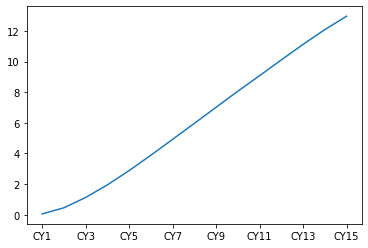

In [17]:
print(ddf_citation_ltc.mean())
ddf_citation_ltc.mean().plot()

In [21]:
def mape(y: pd.DataFrame, ypred: pd.DataFrame) -> float:
    
    err = np.abs(y - ypred) / y
    return 100 * err.mean()


def rmse(y: pd.DataFrame, ypred: pd.DataFrame) -> float:
    err = (y - ypred) ** 2
    return np.sqrt(err.mean())
    
    
# mape(ddf_citation_ltc[ddf_citation_ltc['CY15'] > 0]['CY15'], 
#      2*ddf_citation_ltc[ddf_citation_ltc['CY15'] > 0]['CY5'])

print("Percent variance explained:",
     (rmse(ddf_citation_ltc['CY10'], ddf_citation_ltc['CY10'].mean()) - 
      rmse(ddf_citation_ltc['CY10'], 2.5*ddf_citation_ltc['CY5'])) /
      rmse(ddf_citation_ltc['CY10'], ddf_citation_ltc['CY10'].mean())
     )



Percent variance explained: 0.3418861354945661


In [52]:
ddf_citation_ltc['year'] = ddf_citation_ltc.patent_date.dt.year
ddf_citation_ltc_2004 = ddf_citation_ltc.query("year == 2004")
ddf_citation_ltc_2005 = ddf_citation_ltc.query("year == 2005")
ddf_citation_ltc_2006 = ddf_citation_ltc.query("year == 2006")



In [59]:
for year in range(1980, 2010):
    
    ddf_citation_ltc_year = ddf_citation_ltc.query(f"year == {year}")

    print(f"Percent variance explained {year}:",
     (rmse(ddf_citation_ltc_year['CY10'], ddf_citation_ltc_year['CY10'].mean()) - 
      rmse(ddf_citation_ltc_year['CY10'], 2*ddf_citation_ltc_year['CY5'])) /
      rmse(ddf_citation_ltc_year['CY10'], ddf_citation_ltc_year['CY10'].mean())
     )



Percent variance explained 1980: 0.3463203219935812
Percent variance explained 1981: 0.34576734994448843
Percent variance explained 1982: 0.34610656511679594
Percent variance explained 1983: 0.3723740191019419
Percent variance explained 1984: 0.3859857747624555
Percent variance explained 1985: 0.4147225321810955
Percent variance explained 1986: 0.4206969155219537
Percent variance explained 1987: 0.4076131508279869
Percent variance explained 1988: 0.3876394106893519
Percent variance explained 1989: 0.35700517777403584
Percent variance explained 1990: 0.3455021507967073
Percent variance explained 1991: 0.3555607403112116
Percent variance explained 1992: 0.36273305269729755
Percent variance explained 1993: 0.3613795784604614
Percent variance explained 1994: 0.40308437901853333
Percent variance explained 1995: 0.4111058360087699
Percent variance explained 1996: 0.4643476686246374
Percent variance explained 1997: 0.4591731999949809
Percent variance explained 1998: 0.4524854862846778
Percent

In [187]:
# pip install "git+https://github.com/nvictus/datashader.git@mpl"

In [198]:
import numpy as np

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap, log_cmap
from bokeh.util.hex import hexbin

output_notebook()

Loading BokehJS ...

In [202]:
n = 50000
x = np.random.standard_normal(n)
y = np.random.standard_normal(n)

x=ddf_citation_ltc[~ddf_citation_ltc['CY15'].isnull()]['CY5']
y=ddf_citation_ltc[~ddf_citation_ltc['CY15'].isnull()]['CY10'] 

size = 0.5
bins = hexbin(x, y, size)

p = figure(tools="wheel_zoom,reset", 
           match_aspect=True, 
           background_fill_color='#FFFFFF')
p.grid.visible = False

p.hex_tile(q="q", r="r", size=size, line_color=None, source=bins,
           fill_color=linear_cmap('counts', 'Turbo256', 0, max(bins.counts)))

show(p)

In [307]:
patent_cpc = ddf.map_partitions(lambda x: x[["cpc_subsection_id", "cpc_sequence"]].reset_index().drop_duplicates())
patent_cpc = patent_cpc[patent_cpc.cpc_sequence == '0'].compute()
patent_cpc = patent_cpc.drop(columns=["cpc_sequence"]).set_index("index")

In [308]:
patent_cpc

,cpc_subsection_id
index,
3930271,A63
3930272,A47
3930273,A61
3930274,B63
3930275,A43
...,...
10757847,H05
10757848,H05
10757849,H05


In [360]:
ddf_citation_ltc_cpc = ddf_citation_ltc.join(patent_cpc).dropna(subset=['cpc_subsection_id'])

<AxesSubplot:>

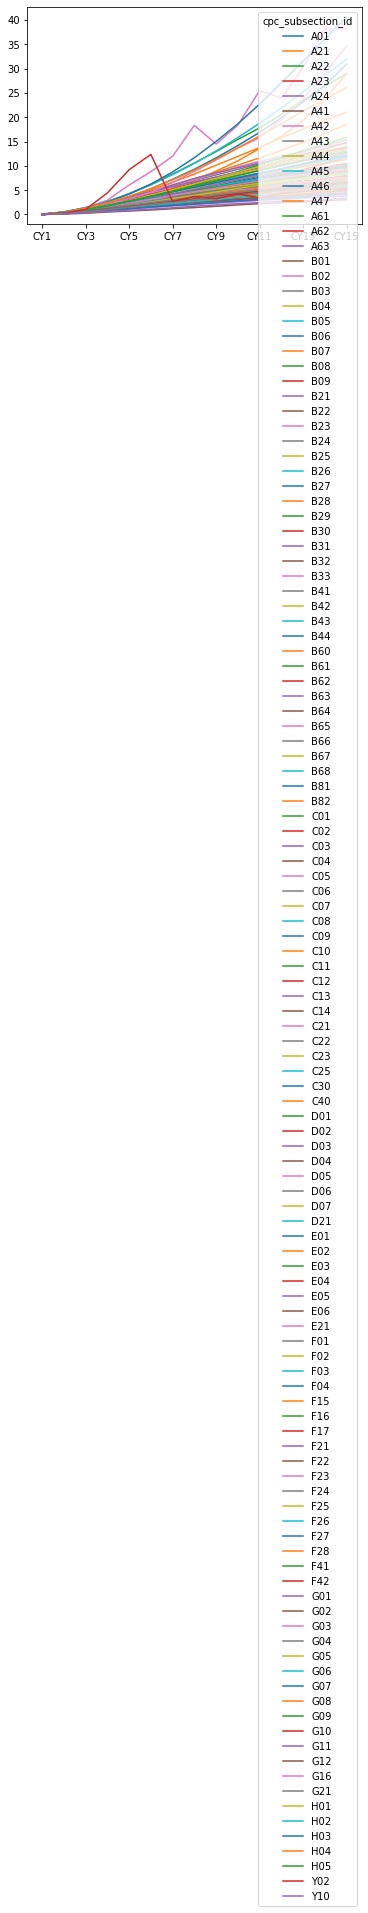

In [311]:
ddf_citation_ltc_cpc.groupby('cpc_subsection_id').mean().T.plot()

In [361]:
ddf_citation_ltc_cpc_ave = ddf_citation_ltc_cpc.groupby('cpc_subsection_id').mean()

In [313]:
correction_5to15 = ddf_citation_ltc_cpc_ave['CY15'] / ddf_citation_ltc_cpc_ave['CY5']

In [315]:
patent_cpc.reset_index().groupby("cpc_subsection_id").nunique()

,index
cpc_subsection_id,
A01,95851
A21,4733
A22,5140
A23,24570
A24,7364
...,...
H03,120724
H04,703588
H05,88636


In [319]:
ddf_citation_ltc_cpc = ddf_citation_ltc_cpc.join(pd.DataFrame(correction_5to15, columns=['correction']), 
                                                 on='cpc_subsection_id')

In [320]:
ddf_citation_ltc_cpc

,CY1,CY2,CY3,CY4,CY5,CY6,CY7,CY8,CY9,CY10,CY11,CY12,CY13,CY14,CY15,patent_date,citedby_patent_date,cpc_subsection_id,correction
index,,,,,,,,,,,,,,,,,,,
3930271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1976-01-06,1992-08-04,A63,4.642749
3930272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1976-01-06,2010-07-13,A47,4.499205
3930273,0.0,0.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,1976-01-06,2020-02-04,A61,6.735095
3930274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1976-01-06,2020-07-21,B63,4.174281
3930275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1976-01-06,2003-12-23,A43,4.620116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10757847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25,NaT,H05,4.679472
10757848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25,NaT,H05,4.679472
10757849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25,NaT,H05,4.679472


<AxesSubplot:>

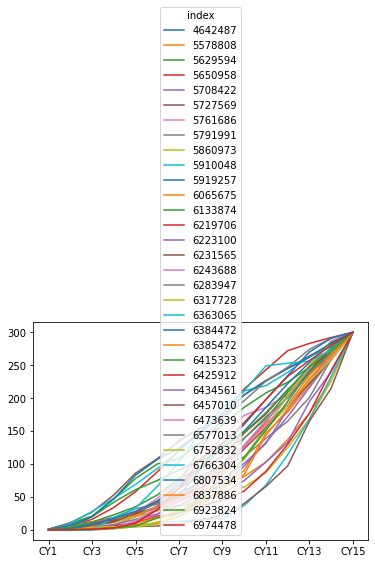

In [358]:
ddf_citation_ltc_cpc.loc[ddf_citation_ltc_cpc['CY15'] == 300, [f"CY{y}" for y in range(1,16)]].T.plot()

<AxesSubplot:>

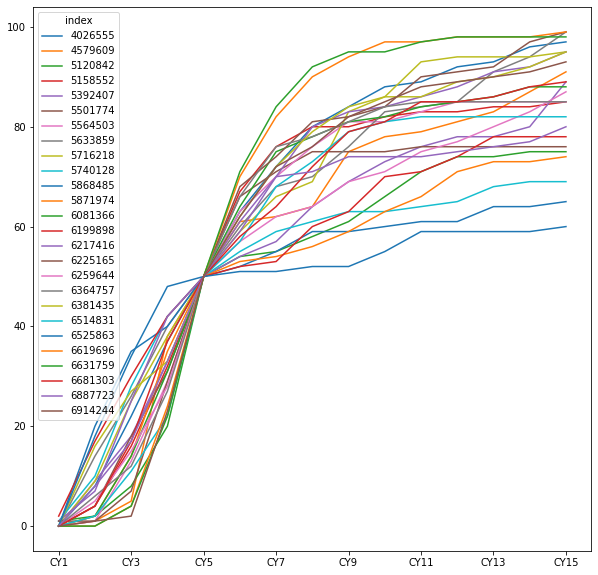

In [386]:
fig, ax = plt.subplots(figsize=(10, 10))

ddf_citation_ltc_cpc.loc[(ddf_citation_ltc_cpc['CY5'] == 50) & (ddf_citation_ltc_cpc['CY15'] < 100), 
                         [f"CY{y}" for y in range(1,16)]].T.plot(ax=ax)

<AxesSubplot:>

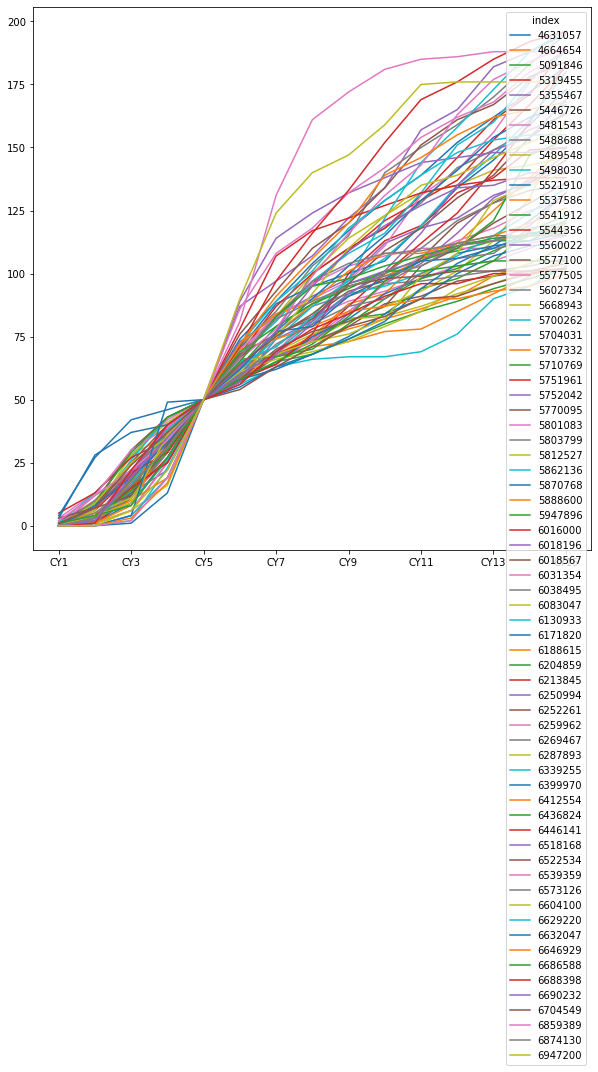

In [388]:
fig, ax = plt.subplots(figsize=(10, 10))

ddf_citation_ltc_cpc.loc[(ddf_citation_ltc_cpc['CY5'] == 50) & 
                         (ddf_citation_ltc_cpc['CY15'] >= 100) &
                         (ddf_citation_ltc_cpc['CY15'] < 200), 
                         [f"CY{y}" for y in range(1,16)]].T.plot(ax=ax)

<AxesSubplot:>

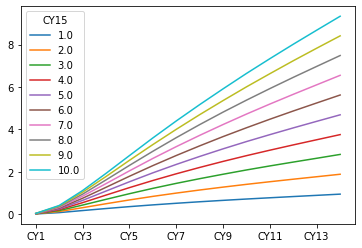

In [376]:
ddf_citation_ltc_cpc.groupby('CY15').mean().loc[1:10].T.plot()

<AxesSubplot:>

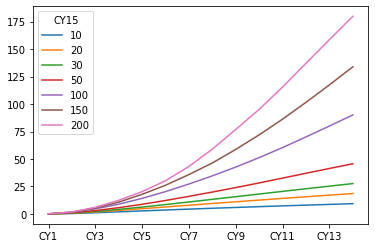

In [372]:
ddf_citation_ltc_cpc.groupby('CY15').mean().loc[[10,20,30,50,100, 150, 200]].T.plot()